# 10k retrieval filtering, 2-step prediction

> Sample size up to 10k, create two-step prediction chain

In [2]:
#| default_exp experiments.retrieval_filtering

In [3]:
#| export
from typing import Dict, List, Any
from pathlib import Path
import os

import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics, model_selection

from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain.schema.runnable import RunnableSequence
from langchain.llms import VertexAI
from langchain.vectorstores import Chroma
from langchain.document_loaders import DataFrameLoader
from langchain.output_parsers import CommaSeparatedListOutputParser

from classifier.schema import WRITE_PREFIX, PROJECT_BUCKET, quota_handler
from classifier.load import Email, get_batches, get_emails_from_frame, \
    get_raw_emails, email_small_enough
from classifier.chroma import get_or_make_chroma
from classifier.predict import write_predictions
from classifier.experiments.split_processing import \
    format_email_for_train_summary, \
    format_email_for_test_summary, \
    make_description_from_row, batch_predict, \
    TRAIN_PROMPT, TEST_PROMPT

# GRPC requires this
os.environ["GRPC_DNS_RESOLVER"] = "native"
EXPERIMENT_PREFIX = "retrieval_filtering"
EXPERIMENT_WRITE_PREFIX = WRITE_PREFIX + "/" + EXPERIMENT_PREFIX

In [4]:
data_dir = Path("../../data")
assert data_dir.exists()
experiment_dir = data_dir / EXPERIMENT_PREFIX
if not experiment_dir.exists():
    experiment_dir.mkdir()

Make sure you're authenticated with google cloud before running this notebook.

## Sample

In [5]:
all_emails = get_raw_emails()

In [6]:
size_mask = all_emails.apply(
    lambda row: email_small_enough(
        row.email_subject,
        row.email_body
    ), axis=1)
size_mask.value_counts()

True     56096
False     1141
Name: count, dtype: int64

Filter on size

In [7]:
all_emails_filtered = all_emails[size_mask]
all_emails_filtered.shape[0]

56096

In [8]:
all_emails_filtered.head(2)

,BU,case_number,ACCOUNT_BUSINESS_UNIT__C,received_at,sfdc_category,sfdc_subcategory,predicted_category,predicted_subcategory,record_type,probability,Accuracy_upd,Bin,email_subject,email_body
0,SPD,3469839,NaN,2023-09-11T13:22:32,Order Processing,Order Entry,Order Processing,NaN,2,0.876806,Correct,8,PO# 7004014842 || Walgreens Store 16422 || Ohi...,External Email â€“ Please use caution before o...
2,PD,3469842,a1G4z00000H4uvREAR,2023-09-11T13:22:43,Order Processing,Order Entry,General Inquiry,NaN,1,0.838036,Incorrect,8,Purchase Order #65398,External Email â€“ Please use caution before o...


Train Test Split

In [9]:
train_idx, test_idx = model_selection.train_test_split(
    all_emails_filtered.index.values,
    test_size=2000,
    train_size=8000,
    stratify=all_emails_filtered.sfdc_category)

In [10]:
all_emails_filtered.loc[train_idx, 'sfdc_category'].value_counts().sort_index(),\
all_emails_filtered.loc[test_idx, 'sfdc_category'].value_counts().sort_index()

(sfdc_category
 Account/Inquiry         1712
 Billing / Invoice        316
 Credits                  128
 Delivery                 258
 General Inquiry          770
 Order Discrepancy        552
 Order Processing        3235
 Pricing                   33
 Product Inquiry          426
 Program / Promotions      34
 Returns                  536
 Name: count, dtype: int64,
 sfdc_category
 Account/Inquiry         428
 Billing / Invoice        79
 Credits                  32
 Delivery                 65
 General Inquiry         193
 Order Discrepancy       138
 Order Processing        809
 Pricing                   8
 Product Inquiry         106
 Program / Promotions      8
 Returns                 134
 Name: count, dtype: int64)

In [11]:
# write_idx(
#     pd.Index(train_idx),
#     pd.Index(test_idx),
#     prefix=EXPERIMENT_WRITE_PREFIX
# )

## Process

In [12]:
training_emails = list(get_emails_from_frame(
    get_raw_emails(),
    'train',
    index_prefix=EXPERIMENT_WRITE_PREFIX
))
len(training_emails)

8000

Load label descriptions

In [13]:
descriptions_path = data_dir / 'labels.xlsx'
assert descriptions_path.exists()

In [14]:
descriptions = pd.read_excel(descriptions_path).map(lambda s: s.strip() if isinstance(s, str) else s)
descriptions_dict = descriptions.T.iloc[1:, :].apply(make_description_from_row, axis=1).to_dict()

Process training data

In [15]:
train_processing_chain = TRAIN_PROMPT | VertexAI()

In [16]:
# # Takes about 2.25 hours
# train_summaries = []

# pbar = tqdm(total=len(training_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(training_emails, 5):
#         batch_prompts = [format_email_for_train_summary(e, descriptions_dict) for e in batch]
#         train_summaries.extend(batch_predict(batch_prompts, train_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(train_summaries) == len(training_emails)

In [17]:
# train_summary_df = pd.DataFrame(
#     zip(
#         train_summaries,
#         [t.idx for t in training_emails],
#         [t.label for t in training_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# train_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_train_summaries.csv', 
#     index=False)

In [18]:
train_summary_df = pd.read_csv(f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_train_summaries.csv')

In [19]:
train_summary_df.head(2)

,summary,idx,label
0,**Summary**\nThe email is about a new purchas...,40220,Order Processing
1,"**Summary:**\nBarbara Conley, an OS&D Analyst...",19920,Credits


Process test data

In [20]:
test_emails = list(get_emails_from_frame(
    get_raw_emails(),
    'test',
    index_prefix=EXPERIMENT_WRITE_PREFIX
))
len(test_emails)

2000

In [21]:
test_processing_chain = TEST_PROMPT | VertexAI()

In [22]:
# # Takes about ~15 minutes
# test_summaries = []

# pbar = tqdm(total=len(test_emails), ncols=80, leave=True)

# try:
#     for batch in get_batches(test_emails, 5):
#         batch_prompts = [format_email_for_test_summary(e) for e in batch]
#         test_summaries.extend(batch_predict(batch_prompts, test_processing_chain))
#         pbar.update(len(batch))
# except:
#     pass
# finally:
#     pbar.close()

# len(test_summaries) == len(test_emails)

In [23]:
# test_summary_df = pd.DataFrame(
#     zip(
#         test_summaries,
#         [t.idx for t in test_emails],
#         [t.label for t in test_emails]
#     ),
#     columns=['summary', 'idx', 'label']
# )
# test_summary_df.to_csv(
#     f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_test_summaries.csv', 
#     index=False)

In [24]:
test_summary_df = pd.read_csv(
    f'gs://{PROJECT_BUCKET}/{EXPERIMENT_WRITE_PREFIX}/split_test_summaries.csv'
).dropna(subset=['summary'])
test_summary_df.shape

(1996, 3)

In [25]:
test_summary_df.head(2)

,summary,idx,label
0,A new purchase order (PO) 6600004025 has been...,35311,Order Processing
1,A fax was received from 7183538134 on 10/31/2...,30312,Delivery


## Vectorstore

Add to chroma

In [26]:
chroma_documents = DataFrameLoader(
    train_summary_df,
    page_content_column='summary').load()
len(chroma_documents)

8000

In [27]:
# Should take about 5 minutes initially
chroma = get_or_make_chroma(
    data_dir=experiment_dir,
    documents=chroma_documents
)

## Prediction (2-step)

1. Get initial prediction, "top 3" of available categories, with descriptions

In [28]:
descriptions_path = data_dir / 'labels.xlsx'
assert descriptions_path.exists()

descriptions = pd.read_excel(descriptions_path).map(lambda s: s.strip() if isinstance(s, str) else s)
descriptions_dict = descriptions.T.iloc[1:, :].apply(make_description_from_row, axis=1).to_dict()

In [29]:
len(descriptions_dict)

14

In [30]:
#| export
def make_categories_str(
        category_descriptions: Dict[str, str], 
        ignore: List[str] = [], 
        include: List[str] = []) -> str:
    if len(include) == 0:
        include = list(category_descriptions.keys())
    return "\n".join(
        [f"||{c}||\n{d.lower().strip()}" for c, d in category_descriptions.items() \
            if (c not in ignore) and (c in include)]
    )

In [31]:
categories_str = make_categories_str(descriptions_dict)
print(categories_str)

||Account/Inquiry||
issues including:
- new account set up
- licensing
- account updates
||Order Processing||
issues including:
- order entry
- will call
- emergency order
- adjust order
- shipping service change
- cancel order
- allocation override
||Delivery||
issues including:
- refused delivery
- deliver/ carrier issue
- missing/ mis-routed tote
||Order Discrepancy||
issues including:
- keying error
- wrong item shipped
- miss label
- overage
- partial carton
- product excursions
- shipped short dated product
- shortage
||Returns||
issues including:
- customer order error
- damage
- expired product
- flu return
- overstock
- product description not clear
- recall
- shipping label/rtn
- short dated product
- unauthorized return
||Billing / Invoice||
issues including:
- freight charge error
||Credits||
issues including:
- billed wrong account
- credit inquiry
- credit not issued / error
- pass thru credit
||Pricing||
issues including:
- product pricing
- pricing issue
||Product Quali

In [32]:
#| export
TOP_3_PROMPT_TEMPLATE = """Below is a summary of an email sent to our customer service department. 
Here is a list of categories and their descriptions we would like to label this email with. 
Of the options in this list, choose your 3 likeliest labels for the following email. 
Only return the categories you choose as a comma-separated list, not their descriptions (the labels surrounded by '||').
-- CATEGORIES --
{categories}
-- EMAIL --
{email}
-- TOP 3 LIKELIEST LABELS --
"""

TOP_3_PROMPT = PromptTemplate.from_template(TOP_3_PROMPT_TEMPLATE)

In [33]:
#| export
_LLM = None


def get_llm() -> VertexAI:
    global _LLM
    if _LLM is None:
        _LLM = VertexAI()
    return _LLM


def get_top_3_chain() -> RunnableSequence:
    return TOP_3_PROMPT | get_llm() | CommaSeparatedListOutputParser()

In [34]:
step_1_chain = get_top_3_chain()

In [35]:
test_summary = test_summary_df.iloc[0, :].summary

In [36]:
example_step_1_answer = step_1_chain.invoke({
    'categories': categories_str,
    'email': test_summary
})
example_step_1_answer

['Order Processing', 'Account/Inquiry', 'General Inquiry']

2. Get 3 most similar examples from the top 3 categories from chroma

In [37]:
chroma.similarity_search(
    test_summary, 
    filter={'label': "Order Processing"},
    k=3)

[Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) 6600005050 from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line of the email indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number 6600005050.\n- The email is labeled as "Order Processing" because it is about a new order.', metadata={'idx': 47696, 'label': 'Order Processing'}),
 Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number, which is 6600002445.\n- The email is labeled as "Order Processing" because it is about a new PO. The label "Order Processing" is used for issues related to order entry, will call, emergency orders, adjusting orders, shipping service changes, canceling orders, and allocation ov

In [38]:
#| export
def get_label_filtered_documents(
        query: str,
        labels: List[str],
        chroma: Chroma,
        k: int = 3
        ) -> Dict[str, List[Document]]:
    documents = {}
    for l in labels:
        label_documents = chroma.similarity_search(
            query,
            filter={'label': l},
            k=k
        )
        documents[l] = label_documents
    return documents

In [39]:
example_filtered_documents = get_label_filtered_documents(
    query=test_summary,
    labels=example_step_1_answer,
    chroma=chroma
)
example_filtered_documents

{'Order Processing': [Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) 6600005050 from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line of the email indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number 6600005050.\n- The email is labeled as "Order Processing" because it is about a new order.', metadata={'idx': 47696, 'label': 'Order Processing'}),
  Document(page_content=' **Summary**\nThe email is about a new purchase order (PO) from CVS Caremark SpecialtyRx.\n\n**Explanation**\n- The subject line indicates that the email is about a new PO from CVS Caremark SpecialtyRx.\n- The body of the email contains the PO number, which is 6600002445.\n- The email is labeled as "Order Processing" because it is about a new PO. The label "Order Processing" is used for issues related to order entry, will call, emergency orders, adjusting orders, shipping service changes, canceling ord

3. Get final prediction

In [69]:
#| export
PREDICTION_TEMPLATE = """Below is a summary of an email sent to our customer service department.
We believe the email to belong to one of categories in the -- CATEGORIES -- list.

We are also providing you with similar examples for each category.
Compare and contrast the examples to the email.
Return the category that best describes the email.
Your answer must be an option in the -- CATEGORIES -- section.

-- CATEGORIES --
{categories}

-- EXAMPLES --
{examples}

-- EMAIL --
{email}

-- CATEGORY --
"""

PREDICTION_PROMPT = PromptTemplate.from_template(PREDICTION_TEMPLATE)

In [70]:
#| export
def get_prediction_chain() -> RunnableSequence:
    return PREDICTION_PROMPT | get_llm()

In [71]:
prediction_chain = get_prediction_chain()

In [72]:
#| export
def format_filtered_examples(examples: Dict[str, List[Document]]) -> str:
    result = ""
    for cat, docs in examples.items():
        cat_header = f"||{cat}|| examples;"
        document_content = "\n".join(
            [
                f"Summary: {d.page_content}\nLabel: {d.metadata.get('label')}\n" for d in docs
            ])
        result = result + cat_header + document_content
    return result

In [73]:
example_prediction = prediction_chain.invoke({
    'categories': make_categories_str(
        descriptions_dict, 
        include=example_step_1_answer),
    'examples': format_filtered_examples(example_filtered_documents),
    'email': test_summary
})
example_prediction

' Order Processing'

In [74]:
#| export
@quota_handler
def invoke_chain(chain: RunnableSequence, *args, **kwargs) -> Any:
    return chain.invoke(*args, **kwargs)

In [75]:
#| export
def get_summary_prediction(
        summary: str, 
        chroma: Chroma, 
        step_1_chain: RunnableSequence,
        step_2_chain: RunnableSequence,
        descriptions: Dict[str, str]) -> str:
    if summary is None:
        return None
    categories_str = make_categories_str(descriptions)
    # Make a prediction for an input summary
    step_1_answer = invoke_chain(
        step_1_chain, 
        {
            'categories': categories_str,
            'email': summary
        })
    # Get similar documents for each likely category
    similar_documents = get_label_filtered_documents(
        query=summary,
        labels=step_1_answer,
        chroma=chroma
    )
    step_2_answer = invoke_chain(
        step_2_chain,
        {
            'categories': make_categories_str(
                descriptions, 
                include=step_1_answer),
            'examples': format_filtered_examples(similar_documents),
            'email': summary
        })
    return step_2_answer.strip()

In [76]:
## For Debugging
# get_summary_prediction(test_summary_df.iloc[15, :].summary, chroma,
#                        step_1_chain, prediction_chain, descriptions_dict)

In [60]:
test_predictions = []

for s in tqdm(test_summary_df.summary, ncols=80, leave=True):
    s_label = get_summary_prediction(
        summary=s,
        chroma=chroma,
        step_1_chain=step_1_chain,
        step_2_chain=prediction_chain,
        descriptions=descriptions_dict
    )
    test_predictions.append(s_label)

100%|█████████████████████████████████████| 1996/1996 [1:55:16<00:00,  3.47s/it]


## Evaluation

In [65]:
pred_kwargs = {
    'y_true': test_summary_df.iloc[:, :].label.tolist(),
    'y_pred': test_predictions
}

In [66]:
metrics.accuracy_score(**pred_kwargs)

0.5791583166332666

In [67]:
print(metrics.classification_report(**pred_kwargs, zero_division=np.nan))

                                           precision    recall  f1-score   support

                          Account Inquiry       0.00       nan       nan         0
                          Account/Inquiry       0.71      0.43      0.54       427
                      Allocation Override       0.00       nan       nan         0
                        Billing / Invoice       0.20      0.66      0.31        79
                                   Claims       0.00       nan       nan         0
                                  Credits       0.36      0.44      0.39        32
                          Damaged Product       0.00       nan       nan         0
                                 Delivery       0.26      0.72      0.38        65
                          General Inquiry       0.29      0.13      0.18       193
             IT Customer Technology Issue       0.00       nan       nan         0
                                Marketing       0.00       nan       nan         0
   

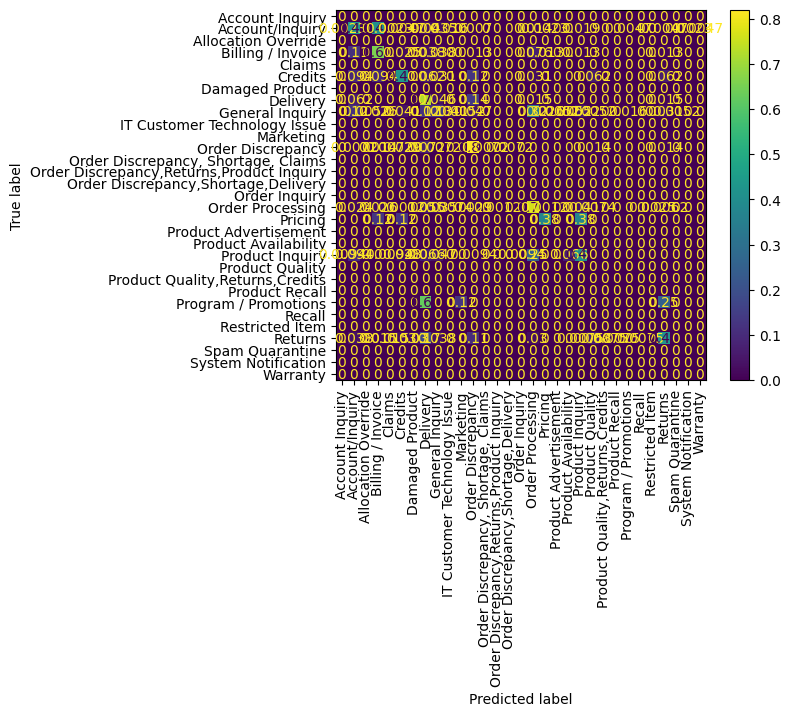

In [68]:
metrics.ConfusionMatrixDisplay.from_predictions(
    normalize='true',
    xticks_rotation='vertical',
    **pred_kwargs
)

## Export

In [77]:
#| hide
import nbdev; nbdev.nbdev_export()